In [ ]:
"""#settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
RANDOM_SEED = 123
Learning_rate = 0.0005
Batch_size = 32
Num_epochs= 10"""

cuda


In [ ]:
"""from google.colab import drive
drive.mount('/content/gdrive')"""

Mounted at /content/gdrive


In [ ]:
#!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
#from google.colab import files

In [ ]:
#!cp /content/gdrive/MyDrive/generate_train.py /content

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


import copy 
import time

In [ ]:
train_set = datasets.FashionMNIST("./data",train=True, download=True,transform=transforms.Compose([transforms.ToTensor()]))
test_set = datasets.FashionMNIST("./data",train=False,download=True,transform=transforms.Compose([transforms.ToTensor()]))      
          

                                                                  

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1024,shuffle=True,num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1024,shuffle=True,num_workers=1)






In [ ]:
print("No of train samples:",str(len(train_loader.dataset)))
print("No of test samples:",str(len(test_loader.dataset)))

No of train samples: 60000
No of test samples: 10000


torch.Size([1, 28, 28])
img torch.Size([28, 28])


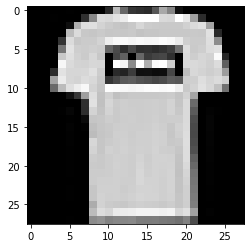

In [ ]:
#sample image from the dataset
img = train_loader.dataset[1][0]
print(img.size())
img_np = img.squeeze(0)
print("img",img_np.size())
plt.imshow(img_np,cmap='gray')

In [ ]:

use_gpu = torch.cuda.is_available()

Autoencoder

In [ ]:
class autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU())
    self.decoder = nn.Sequential(
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,28*28),
        nn.ReLU())
    
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


    


    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

Function to train the network


In [ ]:

def train_model(model,criterion,optimizer,num_epochs):
  start = time.time()
  train_loss = []

  for epoch in range(num_epochs):
    epochStartTime = time.time()
    print("Epoch {}/{}".format(epoch,num_epochs-1))

    running_loss = 0.0
    # Load data in batches

    batch = 0
    for data in train_loader:
      inputs,labels = data

      #if use_gpu:
      inputs, labels = inputs.to(device), labels.to(device)
      
      #print(inputs.size())
      inputs = inputs.reshape(-1,28*28)
      #print(inputs.size())
      model.zero_grad()
      outputs = model(inputs)
      #print(',',outputs.size())
      #print(':',inputs.size())
      loss = criterion(outputs,inputs)
      #print('loss',loss)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if batch ==0:
        totalLoss = loss
        batch+=1
      else:
        totalLoss+=loss
        batch+=1
    epoch_loss = running_loss/50000
    train_loss.append(epoch_loss) #saving the loss over epochs for plot

    print('Epoch loss:{:.6f}'.format(epoch_loss))
    print('train_loss',train_loss)
    epochEndTime = time.time()-epochStartTime
    print('Epoch complete in {:.0f}m {:.0f}s'.format(epochEndTime//60,epochEndTime%60))
    print('-'*25)
    #plotting loss vs epochs
    fig1 = plt.figure(1)
    plt.plot(range(epoch+1),train_loss,'r--',label = 'train')
    if epoch == 0:
      plt.legend(loc ='upper left')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
    fig1.savefig('aeRecon_lossplot.png')

  time_elapsed = time.time()-start
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
  return model

In [ ]:

#model initialization and training
net = autoencoder()
print(net)
net = net.to(device)
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
)


Epoch 0/1
Epoch loss:0.000154
train_loss [0.00015393192663788795]
Epoch complete in 0m 9s
-------------------------
Epoch 1/1
Epoch loss:0.000115
train_loss [0.00015393192663788795, 0.00011488455519080162]
Epoch complete in 0m 9s
-------------------------
Training complete in 0m 18s


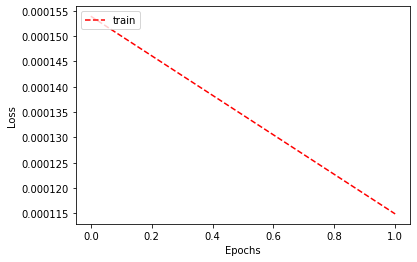

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(),lr = 0.5, momentum=0.9)
net = train_model(net,criterion,optimizer,num_epochs=2)

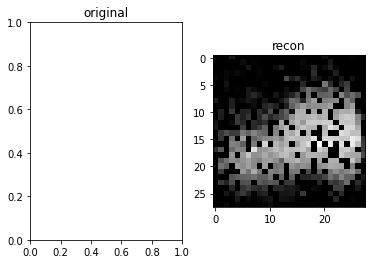

In [ ]:
TestImg = test_loader.dataset[0][0]
#TestImg1 = TestImg.reshape(-1,28*28)
outputImg = net(TestImg.reshape(-1,28*28).to(device))

outputImg = outputImg.data.view(-1,28,28).cpu()

fig = plt.figure()
plot = fig.add_subplot(1,2,1)
img = TestImg.squeeze(0)
plot.set_title("original")

plot = fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title("recon")

imgplot=plt.imshow(img,cmap='gray')
plt.show()



torch.Size([1, 28, 28])
img torch.Size([28, 28])


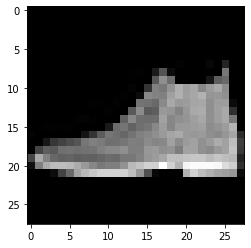

In [ ]:
#sample image from the dataset
img = test_loader.dataset[0][0]
print(img.size())
img_np = img.squeeze(0)
print("img",img_np.size())
plt.imshow(img_np,cmap='gray')